In [1]:
import os
import numpy as np
from scipy import integrate
import mdtraj
import matplotlib.pyplot as plt
%matplotlib inline

## Objective
Calculate the self-diffusion coefficient of TIP3P water from a molecular dynamics simulation.  
The reference value is $5.19 \times 10^{-5} cm^2/s$. (See below for source.)  
**Final answer, calculated from single water molecule =** $-7.02 \times 10^{-10} cm^2/s$  
Yes, wrong answer. TODO: rerun simulation with snapshots every 1 fs instead of every 100 fs.

*Calculation parameters:*  
Data files and example input files in Github repo. Basic details:
- 1001 water molecules
- 31x31x31 Angstrom box
- 2 fs/time step
- data is taken every 0.1 ps (every 50 steps = every 100 fs)
- Temperature of 308 K


## Theory
This notebook makes use of the Green-Kubo relation, such as derived [here][1] to Eqn. 162.
- Components of x, y, z are added after integration
- Remember the factor of 3 after summing components


This code can be extended or repurposed for calculating diffusivity in an inhomogeneous system, such as a lipid bilayer (such as eq 4 [here][3]).

## Units
- Use the conversion factor for velocities from NAMD binary file [details][4]. This goes from internal units to  Angstroms/picosecond.
- Normalized autocorrelations don't have units. They're divided out as part of the normalization process. 
- Non-normalized autocorrelations have the original data's units squared.
- mdtraj loads thing in units of nm! That means if namd xyz says 0.163805, mdtraj loaded xyz says 0.0163805

## Reference data
From the web, literature, etc.
1. [Table of self-diffusion coefficients based on water model][5]
2. [Correlation function as a function of time][6] (I think this was normalized)
3. [Bit of background stat mech in these slides][7] (though the scale of VACF and diffusion coefficient is different, maybe they had a diff. setup)
4. In this [paper][8], fig 3 has clear plots and shows importance of small (< 1 ps) time step for recording data
5. Autocorrelation function:
    1. Equation in Leach for [velocity autocorrelation function][2] (p. 376).
    2. Good way of [visualizing][9] how the time correlation function works (also good background material in rest of slides)
6. If setting up new system for testing, remember to [consider the water density][10].
7. [Water's self-diffusion coefficient as a function of temperature][11]
8. Other work on TIP3P: [1][12]
9. If using multiple atoms, find average velocity by weighting by atomic mass. I.e., Use center-of-mass velocity. Example VACF like [this][13].
10. Obviously don't use the restrained water for VACF calculation.
11. For averaging over all water molecules, don't average raw velocities. Average after calculating ACF on each molecule. If you plot `vels_all_avg`, you'd see that the scale is +-0.00015 A/ps for average as opposed to +-15 A/ps for individual water molecules.

## TODO
1. Calculate position ACF to calculate diffusion coefficient for the restrained water (first one).
2. Parallelize the calcACF (also compare timings). Briefly tried this but the function would never finish executing even after ~20 min for a single calcACF run. Each ACF calculation as it is now is about 2.8 minutes.
    1. Resources: [here](https://stackoverflow.com/questions/42550529/dask-how-would-i-parallelize-my-code-with-dask-delayed?rq=1) and [here](http://dask.pydata.org/en/latest/delayed-overview.html)


[1]: http://www.pages.drexel.edu/~cfa22/msim/node29.html
[2]: http://archive.ambermd.org/201305/att-0347/autocorrelation.jpg
[3]: http://pubs.acs.org/doi/full/10.1021/acs.jctc.6b00747
[4]: http://www.ks.uiuc.edu/Research/namd/mailing_list/namd-l.2008-2009/0435.html 
[5]: http://www1.lsbu.ac.uk/water/water_models.html
[6]: http://www.chem.pku.edu.cn/liujian/tutorial-lscivr/tutorial-lscivr.html#351-diffusion-constant
[7]: http://www.ks.uiuc.edu/Training/SumSchool/materials/lectures/6-3-Statistical-Mechanics-Proteins/1-ik_diffusion.pdf
[8]: https://istina.msu.ru/media/publications/articles/304/d61/3161642/water_en_2012.pdf
[9]: http://www.eng.buffalo.edu/~kofke/ce530/Lectures/Lecture12/sld012.htm
[10]: http://www.ks.uiuc.edu/Research/namd/mailing_list/namd-l.2003-2004/0911.html
[11]: http://pubs.rsc.org/en/content/articlepdf/2000/cp/b005319h
[12]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3193570/
[13]: http://bit.ly/2D2iKeQ

In [2]:
def readXYZnamd(infile):
    """
    Read in a pre-processed XYZ file from NAMD. 
    
    This was obtained from the NAMD binary file using the catdcd utility:
      'catdcd -s waterbox.psf -stype psf -i solu.index -o vels_0.xyz -otype xyz usWat-1.veldcd'
      Here, usWat-1.veldcd is the name of the binary file, and 
      solu.index is a plain ASCII file with 0 1 2 each on a new line bc those are the indices
      of the OH2, H1, H2 atoms of my specific water molecule.
      See more: http://www.ks.uiuc.edu/Development/MDTools/catdcd/
    The file was processed to remove all lines that didn't have velocity data.
    
    Parameter
    ---------
    infile: string name of pre-processed XYZ file 
    
    Returns
    -------
    vel*: numpy arrays of the 1st, 2nd, and 3rd columns in the file
    """
    velx, vely, velz = np.loadtxt(infile, usecols=(1,2,3), dtype=float, unpack=True)

    # internal namd units  --[* 20.45482706] --> Angstroms/picosecond
    # Angstroms/picosecond --[* 100.0]       --> m/s
    velx, vely, velz = 20.45482706*velx, 20.45482706*vely, 20.45482706*velz
    
    return velx, vely, velz

In [3]:
def calcCOM(inlist):
    """
    Calculate center of mass of the given timeseries.
       x_CM = (m1*x1 + m2*x2 + m3*x3) / (m1 + m2 + m3)

    Parameter
    ---------
    inlist: list of tuples, where each tuple is (weight, listData)
             ex., [(atomMass1, list1), (atomMass2, list2)]

    Returns
    -------
    final: list of center of mass of all the tuple list components

    """
    weighted = []
    denom = []
    for i in inlist:
        denom.append(i[0])
        weighted.append(i[0]*i[1])
    numerator = np.sum(weighted, axis=0)
    denominator = np.sum(denom)
    final = numerator / denominator
    return final

In [4]:
def calcACF(series, norm=False):
    """
    Calculate the autocorrelation function of the given timeseries.
    Modified code from David Wych.
       Cz(t) = 1/nSamples sum[ deltaZ(i) * deltaZ(i+t), {i=0, imax=nSamples} ]
       deltaZ(i) = z(i) - avgZ
    
    Parameters
    ----------
    series: numpy list of data from which to calculate the autocorrelation function
    norm: Boolean variable, whether to normalize output or not
    
    Returns
    -------
    C*: list containing the autocorrelation function
    
    
    """
    # assign cutoff from half of timeseries data
    N = len(series)
    cutoff = int(N/2)
    avg = np.average(series)
    
    # calculate ACF here
    lt = 0
    C_prime = []
    while lt <= cutoff:
        temp = []
        nSamples = N-lt
        for i in range(nSamples):
            temp.append((series[i]-avg)*(series[i+lt]-avg))
        term = np.sum(temp)/nSamples
        C_prime.append(term)
        lt += 1

    if not norm:
        return np.asarray(C_prime)

    # normalization: since working with dZs, use norm of dZ vector
    # I don't know if this is right...
    norms = []
    for i in range(N):
         norms.append((series[i]-avg)**2)
    normConst = np.sum(norms)/N # take average
    print(normConst)
    C = C_prime/normConst
    return C

In [5]:
# Load data
velx_0, vely_0, velz_0 = readXYZnamd('run2/vels_3000.xyz')
velx_1, vely_1, velz_1 = readXYZnamd('run2/vels_3001.xyz')
velx_2, vely_2, velz_2 = readXYZnamd('run2/vels_3002.xyz')

Text(0,0.5,'$\\AA$/ps')

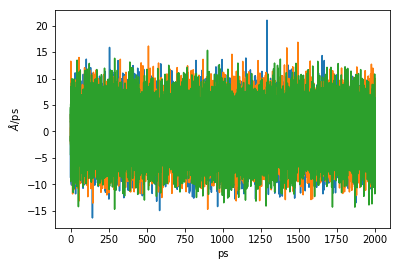

In [6]:
# Visualize velocity data
plt.plot(np.arange(len(velx_0))/10,velx_0)
plt.plot(np.arange(len(vely_0))/10,vely_0)
plt.plot(np.arange(len(velz_0))/10,velz_0)
plt.xlabel('ps')
plt.ylabel('$\AA$/ps')  # if dividing x-values by 10, use A/ps
#plt.ylabel('m/s')

In [7]:
# calculate center of mass of each component
velx_wat1 = [(16., velx_0), (1.01, velx_1), (1.01, velx_2)]
velx_com = calcCOM(velx_wat1)

vely_wat1 = [(16., vely_0), (1.01, vely_1), (1.01, vely_2)]
vely_com = calcCOM(vely_wat1)

velz_wat1 = [(16., velz_0), (1.01, velz_1), (1.01, velz_2)]
velz_com = calcCOM(velz_wat1)

Text(0,0.5,'$\\AA$/ps')

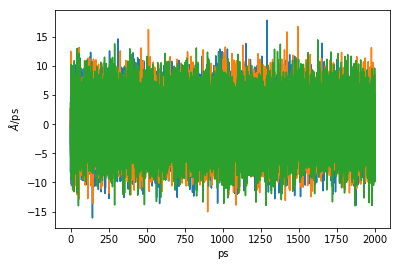

In [8]:
# visualize to make sure nothing went awry
# resulting plot should be much closer to O than to the 2 Hs
plt.plot(np.arange(len(velx_com))/10,velx_com)
plt.plot(np.arange(len(vely_com))/10,vely_com)
plt.plot(np.arange(len(velz_com))/10,velz_com)
plt.xlabel('ps')
plt.ylabel('$\AA$/ps') # if dividing x-values by 10, use A/ps
#plt.ylabel('m/s')

In [9]:
# calculate the autocorrelation function for each velocity component
acf_x = calcACF(velx_com, norm=False)
acf_y = calcACF(vely_com, norm=False)
acf_z = calcACF(velz_com, norm=False)

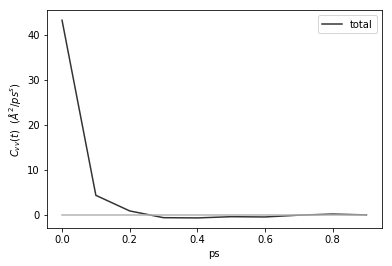

In [17]:
acf_sum = acf_x + acf_y + acf_z

# visualize the ACF
trim = 10
#plt.plot(np.arange(len(acf_x[:trim]))/10,acf_x[:trim], label='x')
#plt.plot(np.arange(len(acf_y[:trim]))/10,acf_y[:trim], label='y')
#plt.plot(np.arange(len(acf_z[:trim]))/10,acf_z[:trim], label='z')
plt.plot(np.arange(len(acf_sum[:trim]))/10,acf_sum[:trim], label='total', c='0.2')
plt.plot(np.arange(len(acf_z[:trim]))/10,np.zeros(len(acf_z[:trim])), c='0.7')
plt.xlabel('ps')
plt.ylabel('$C_{vv}(t) \ \ (\AA^2/ps^s)$')
plt.legend()

In [11]:
diff = integrate.simps(acf_sum, dx=0.1)/3*1e-8
# check by component
diffx, diffy, diffz = integrate.simps(acf_x, dx=0.1), integrate.simps(acf_y, dx=0.1), integrate.simps(acf_z, dx=0.1)
print(diffx, diffy, diffz, diff)
diff_tot_scaled = sum([diffx, diffy, diffz])/3*1e-8 # m2/s: (1e-20) A2 to m2, (1e12) 1/ps to 1/s
diff_tot_scaled

0.0643324787958 -0.0166614704669 -0.258337144528 -7.02220453997e-10


-7.0222045399747234e-10